In [33]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf

In [34]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

RuntimeError: Physical devices cannot be modified after being initialized

In [4]:
for gpu in gpus:
  print(gpu)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [5]:
ds=tfds.load('fashion_mnist',split='train')

2025-05-29 15:31:22.900980: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-05-29 15:31:22.901019: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-05-29 15:31:22.901025: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-05-29 15:31:22.901060: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-29 15:31:22.901073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [1]:
ds.as_numpy_iterator().next()

NameError: name 'ds' is not defined

### Viz Data and Build Dataset

In [3]:
import numpy as np

In [8]:
data_itr=ds.as_numpy_iterator()

In [9]:
data_itr.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

In [10]:
import matplotlib.pyplot as plt

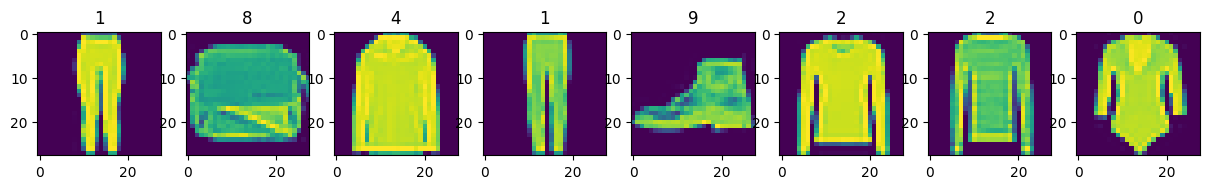

In [11]:
fig,ax =plt.subplots(ncols=8,figsize=(15,15))
for idx in range(8):
  batch=data_itr.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])

In [35]:
def scale_image(data):
  image=data['image']
  return image/255

In [36]:
#Reload the Dataset
ds=tfds.load('fashion_mnist',split='train')
#Running the dataset through the scale_images preprocessing step
ds=ds.map(scale_image)
#Cache the dataset for that batch
ds=ds.cache()
#Shuffle the data
ds=ds.shuffle(60000)
#Batch into 128 images per sample
ds=ds.batch(128)
# Reduces the likelihood of bottlenecking
ds=ds.prefetch(64)

In [20]:
print('(sample,pix,pix, )')
ds.as_numpy_iterator().next().shape

(sample,pix,pix, )


(128, 28, 28, 1)

## Build the Neural Network

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense,Flatten,Reshape,LeakyReLU,Dropout,UpSampling2D

### Build Generator

In [10]:
def build_generator():
  model=Sequential()
  # Take in random values and reshapes it to 7x7x128
  # Beginnings of a generator image
  model.add(Dense(7*7*128,input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128,5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 2
  model.add(Conv2D(128,4,padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv layer to get to one channel
  model.add(Conv2D(1,4,padding='same',activation='sigmoid'))

  return model

In [13]:
generator=build_generator()
generator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
image=generator.predict(np.random.randn(4,128,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


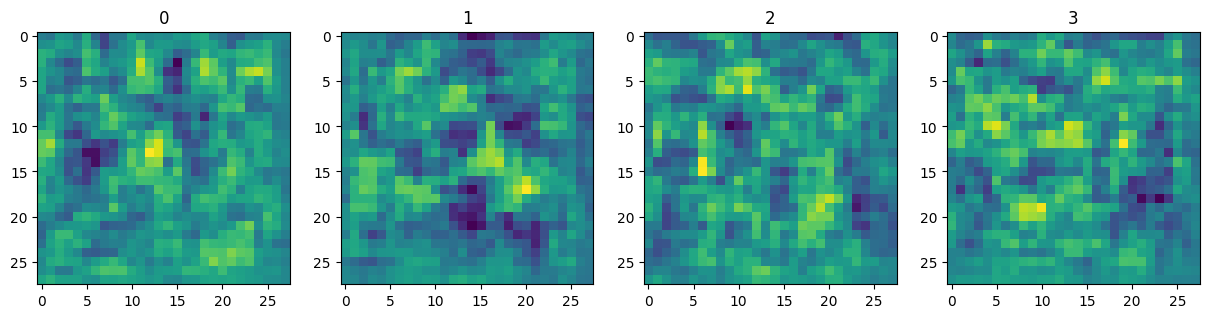

In [42]:
image=generator.predict(np.random.randn(4,128,1))
fig,ax =plt.subplots(ncols=4,figsize=(15,15))
for idx , img in enumerate(image):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)

### Build Discriminator

In [43]:
def build_discriminator():
  model=Sequential()

  # First conv Block
  model.add(Conv2D(32,5,input_shape=(28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Second Conv block
  model.add(Conv2D(64,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Third Conv block
  model.add(Conv2D(128,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  #Fourth Conv block
  model.add(Conv2D(256,5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten and output
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))


  return model

In [10]:
discriminator=build_discriminator()
discriminator.summary()

/Users/abhishekkanade/Documents/notebook/My_Project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 20, 20, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 12, 12, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        36,865 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113,345 (4.25 MB)

 Trainable params: 1,113,345 (4.25 MB)

 Non-trainable params: 0 (0.00 B)

In [44]:
discriminator.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


array([[0.07864381],
       [0.07861205],
       [0.0786834 ],
       [0.07861754]], dtype=float32)

## Construct Training Loop

### Setup Losses and Optimizer

In [45]:
# Adam is going to be the optimizer both discriminator and generator
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy

In [46]:
gen_opt=Adam(learning_rate=0.0001)
dis_opt=Adam(learning_rate=0.00001)
gen_loss=BinaryCrossentropy()
dis_loss=BinaryCrossentropy()

### Build Subclassed Model

In [47]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [25]:
tf.random.normal((6,128,1))

<tf.Tensor: shape=(6, 128, 1), dtype=float32, numpy=
array([[[ 9.05255020e-01],
        [-1.21622956e+00],
        [ 1.89013457e+00],
        [-8.17474604e-01],
        [ 5.41033685e-01],
        [ 6.10120833e-01],
        [-2.81187266e-01],
        [ 1.62210870e+00],
        [ 7.83110201e-01],
        [-1.14495635e-01],
        [ 6.90198720e-01],
        [ 3.10722858e-01],
        [-3.20672333e-01],
        [ 1.10452533e+00],
        [ 1.11287570e+00],
        [-2.99647003e-01],
        [-9.27617997e-02],
        [ 1.96474373e+00],
        [-1.85345769e-01],
        [-4.38951775e-02],
        [-2.54057616e-01],
        [-7.70734966e-01],
        [-1.91897571e-01],
        [-1.49517968e-01],
        [ 8.60945761e-01],
        [-9.57839251e-01],
        [ 2.89634675e-01],
        [ 1.33126712e+00],
        [ 1.20482838e+00],
        [-1.01625478e+00],
        [ 1.06183338e+00],
        [-1.73526311e+00],
        [-4.94445145e-01],
        [-2.49669794e-02],
        [ 5.45335054e-01],
  

In [48]:
class FashionGAN(Model):
  def __init__(self,generator,discriminator,*args,**kwargs):
    # Pass through args and kwargs to base class
    super().__init__(*args,**kwargs)

    # Create attributes fro gen and disc
    self.generator=generator
    self.discriminator=discriminator

  def compile(self,gen_opt,dis_opt,gen_loss,dis_loss,*args,**kwargs):
    # Compile with base class
    super().compile(*args,**kwargs)

    # Create attributes for optimizer and losses
    self.gen_opt=gen_opt
    self.dis_opt=dis_opt
    self.gen_loss=gen_loss
    self.dis_loss=dis_loss
  @tf.function
  def train_step(self, batch): # Added batch as an argument
    # Get real image
    real_images=batch
    # Ensure latent vector shape matches generator input layer (batch size, latent_dim)
    fake_images=self.generator(tf.random.normal((tf.shape(real_images)[0], 128)),training=False)

    # Train the discriminator
    with tf.GradientTape() as d_tape:
      # Pass the real and fake image to the discriminator model
      yhat_real=self.discriminator(real_images,training=True)
      yhat_fake=self.discriminator(fake_images,training=True)
      yhat_real_fake=tf.concat([yhat_real,yhat_fake],axis=0)

      # Create Labels for real and fake images
      y_real_fake=tf.concat([tf.zeros_like(yhat_real),tf.ones_like(yhat_fake)],axis=0)

      # Add some noise to the outputs
      noise_real= 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake= -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_real_fake+=tf.concat([noise_real,noise_fake],axis=0)

      # Calculate loss
      total_dis_loss=self.dis_loss(y_real_fake,yhat_real_fake)

    # Apply backpropgation -nn layer
    dgrad=d_tape.gradient(total_dis_loss,self.discriminator.trainable_variables)
    self.dis_opt.apply_gradients(zip(dgrad,self.discriminator.trainable_variables))

    with tf.GradientTape() as g_tape:
      # Generate some new images
      # Ensure latent vector shape matches generator input layer (batch size, latent_dim)
      gen_images=self.generator(tf.random.normal((tf.shape(real_images)[0], 128)),training=True)

      # Create the predicted labes
      predicted_labels=self.discriminator(gen_images,training=False)

      # Calculate Loss
      total_gen_loss=self.gen_loss(tf.zeros_like(predicted_labels),predicted_labels)

    #Apply Backpropagation
    ggrad=g_tape.gradient(total_gen_loss,self.generator.trainable_variables)
    self.gen_opt.apply_gradients(zip(ggrad,self.generator.trainable_variables))

    return {"d_loss":total_dis_loss,"g_loss":total_gen_loss}

In [49]:
# Create  instance of subclass model
fashion_gan=FashionGAN(generator,discriminator)

In [50]:
fashion_gan.compile(gen_opt,dis_opt,gen_loss,dis_loss)

### Build Callbacks

In [51]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [52]:
class ModelMonitor(Callback):
  def __init__(self,num_img=3,latent_dim=128):
    self.num_img=num_img
    self.latent_dim=latent_dim
    os.makedirs('images', exist_ok=True)


  def on_epoch_end(self,epoch,logs=None):
    random_latent_vectors=tf.random.uniform((self.num_img,self.latent_dim))
    generated_images=self.model.generator(random_latent_vectors)
    generated_images *=255
    generated_images.numpy()
    for i in range(self.num_img):
      img=array_to_img(generated_images[i])
      img.save(os.path.join('images','generated_img_%03d_%d.png'%(epoch,i)))


### Train

In [31]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

In [56]:
generator.load_own_variables('/Users/abhishekkanade/Documents/notebook/My_Project/GAN/generatormodel.h5')
discriminator.load_weights("/Users/abhishekkanade/Downloads/discriminator_weight.weights.h5")

AttributeError: 'str' object has no attribute 'keys'

In [ ]:
hist=fashion_gan.fit(ds,epochs=1,callbacks=[ModelMonitor()])

Epoch 1/2
362/469 ━━━━━━━━━━━━━━━━━━━━ 2:25 1s/step - d_loss: 0.5977 - g_loss: 1.1307

KeyboardInterrupt: 

### Review Performance

In [27]:

plt.plot(hist.history['d_loss'],label='d_loss')
plt.plot(hist.history['g_loss'],label='g_loss')
plt.legend()
plt.show()

NameError: name 'hist' is not defined

## Test out the Generator

In [29]:
imgs=generator.predict(tf.random.normal((16,128,1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


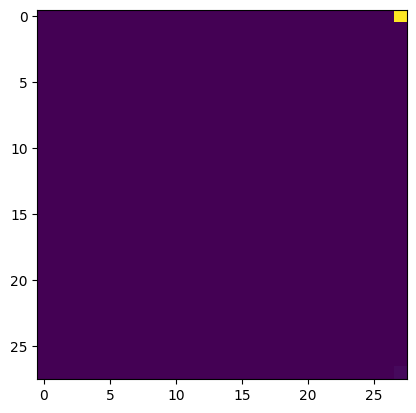

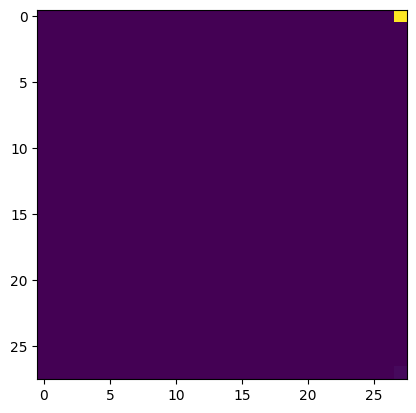

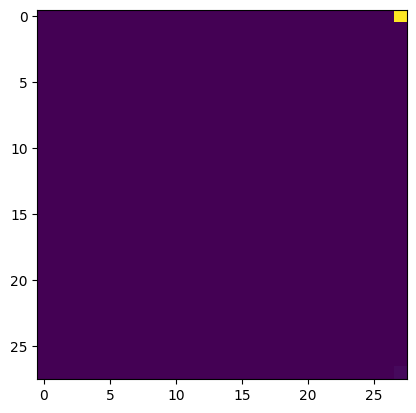

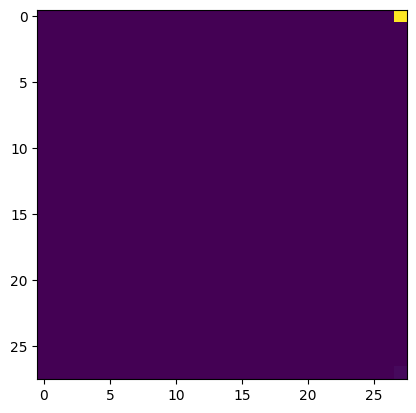

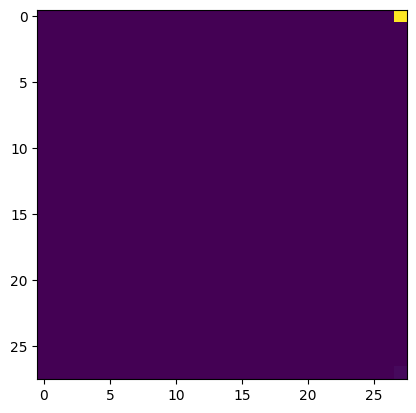

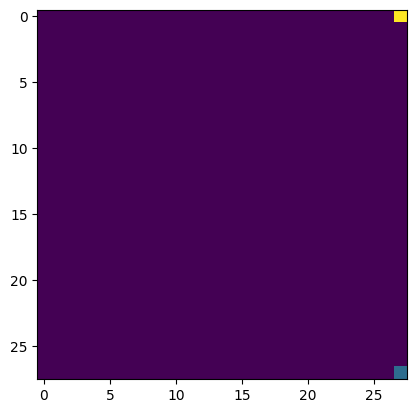

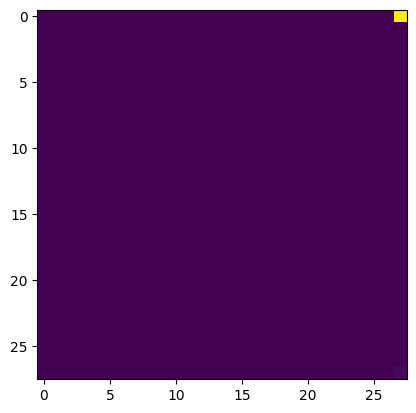

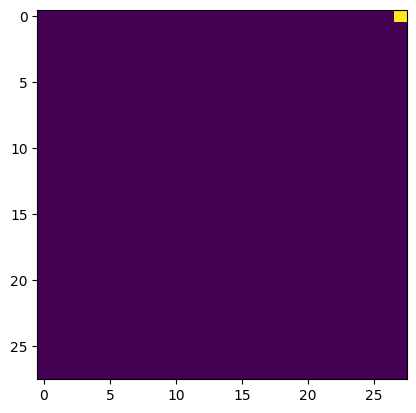

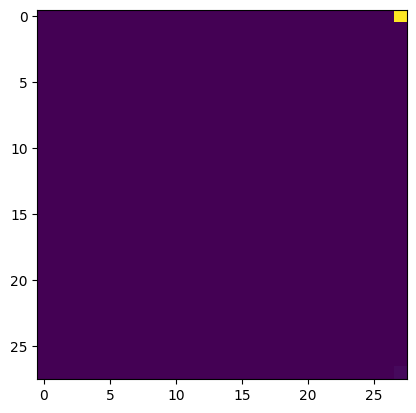

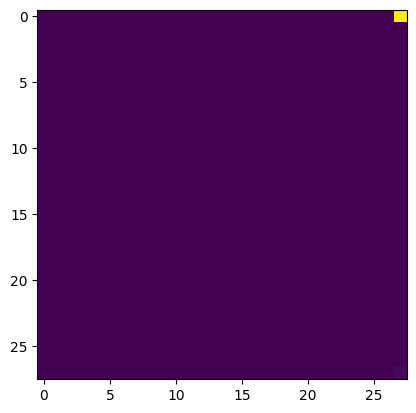

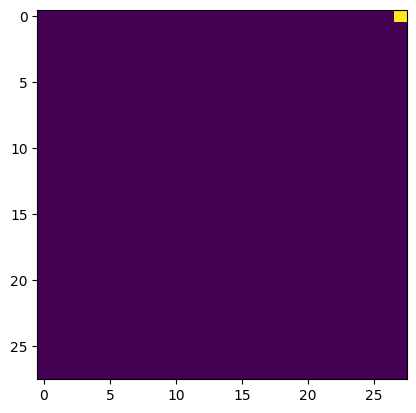

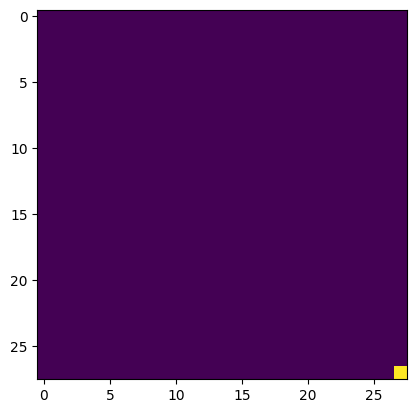

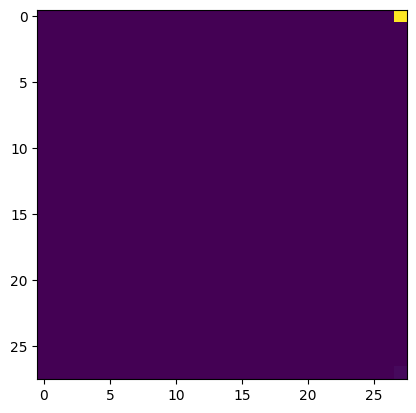

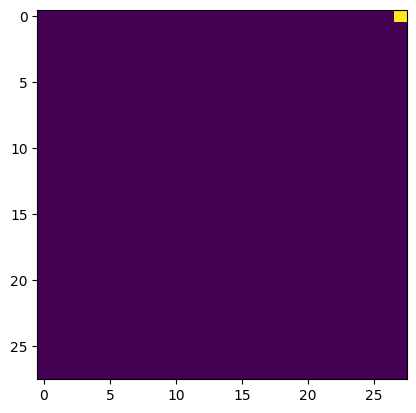

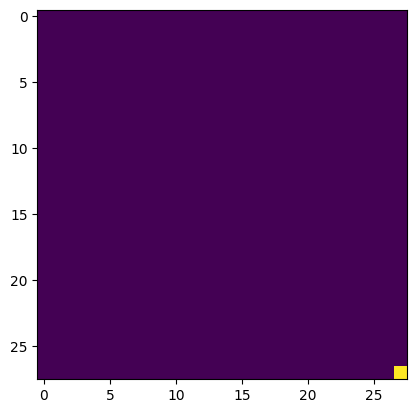

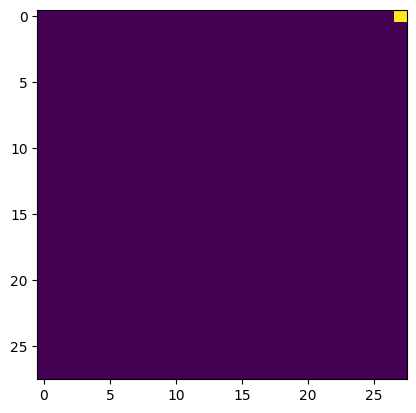

In [30]:
for c in range(4):
  for r in range(4):
    plt.imshow(imgs[(r)*(c)])
    plt.show()


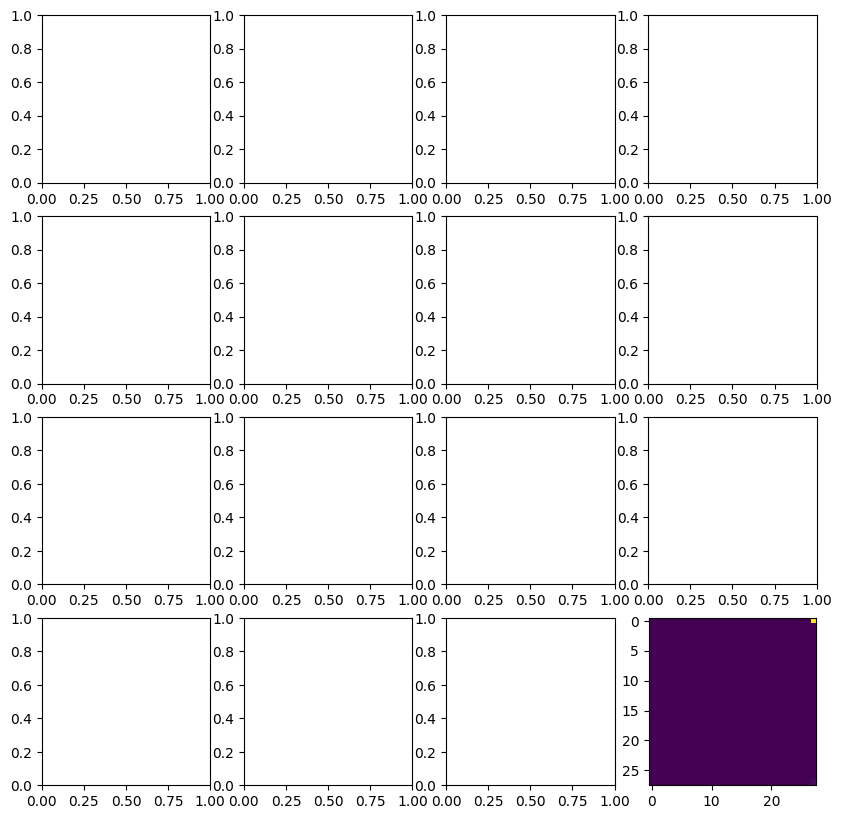

In [17]:
fig,ax=plt.subplots(ncols=4,nrows=4,figsize=(10,10))
for r in range(4):
  for c in range(4):
    ax[r][c]=plt.imshow(imgs[(r)*(c)])

### Save Model

In [35]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [37]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Is built with GPU support:", tf.test.is_built_with_gpu_support())
print("Physical devices (GPU):", tf.config.list_physical_devices('GPU'))

# Test operation
a = tf.random.normal((1000, 1000))
b = tf.random.normal((1000, 1000))
c = tf.matmul(a, b)
print("Test matrix multiplication successful")


TensorFlow version: 2.16.2
Is built with GPU support: False
Physical devices (GPU): []
Test matrix multiplication successful


In [5]:
! pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.6/252.6 MB 6.1 MB/s eta 0:00:0000:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 671.4/671.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 5.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflowm━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/3 [tensorboard]
    Found existing installation: tensorflow 2.16.2━━━━━━━━━━━━ 1/3 [tensorboard]
    Uninstalling tensorflow-2.16.2:╸━━━━━━━━━━━━━ 2/3 [tensorflow]
      Successfully uninstalled tensorflow-2.16.2━━━━━━━━━━━━━ 2/3 [tensorflow]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [tensorflow]3 [tensorflow]
ERROR: pip's dependency 

In [2]:
import tensorflow as tf

In [6]:
model=tf.keras.models.load_model('/Users/abhishekkanade/Documents/notebook/My_Project/GAN/generatormodel.h5')

TypeError: Error when deserializing class 'Conv2DTranspose' using config={'name': 'conv2d_transpose_42', 'trainable': True, 'dtype': 'float32', 'filters': 64, 'kernel_size': [5, 5], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'output_padding': None}.

Exception encountered: Unrecognized keyword arguments passed to Conv2DTranspose: {'groups': 1}